In [449]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
warnings.filterwarnings('ignore')

In [3]:
def good_robust_redrock_redshift(data):
    search = (data['dz']<=0.0033) & (data['best_quality']>=2.5)
    search_bad = (data['dz']>0.0033) | (data['best_quality']<2.5)
    search_bad_1 = (data['dz']>0.0033) & (data['best_quality']>=2.5)
    search_bad_2 = (data['dz']<0.0033) & (data['best_quality']<2.5)
    only_good_quality = data['best_quality']>=2.5
    return data.loc[search], data.loc[search_bad],data.loc[search_bad_1],data.loc[search_bad_2],data.loc[only_good_quality]

In [358]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2,good_quality_data = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)
    #print(Total_good_number)
    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2,good_quality_data = good_robust_redrock_redshift(SV_depth_catalog_cut)
    #print(Total_cut_number)
    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number
    Data_completeness = len(good_catalog)*1.0/Total_number

    #print('Redshift purity:', Redshift_success_rate)
    #print('Good data completeness:', Good_data_completeness)
    #print('Data completeness:', Data_completeness)
    #print('Combined value:',Redshift_success_rate*Good_data_completeness)
    return Redshift_success_rate,Good_data_completeness, Data_completeness, Total_number

# The metric definitation

### *Redshift purity - what is the fraction of objects with reliable redshfits in a given selection.


### *Redshift completeness - what is the fraction of objects with reliable redshifts among the observations. 



1. Reading the cascades LRG catalog with VI

In [159]:
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
dataname = 'allVItiles_LRGzinfo_wVI.fits'
catalog = Table.read(diretory+dataname)
catalog = catalog[catalog['N_VI']>0]

In [160]:
vi_catalog = catalog
len(set(vi_catalog['TARGETID']))

3561

The first part is directly using VI deep fields to check the redshift purity and completeness

1. For the SV selection

In [443]:
new_catalog = vi_catalog[['TARGETID','Z','subset','TILEID','EFFTIME_DARK','DELTACHI2','FIBER','best_z','best_quality','EBV','FIBERFLUX_Z']].to_pandas()
new_catalog['dz'] = abs(new_catalog['Z']-new_catalog['best_z'])/(1.+new_catalog['best_z'])
new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']

new_catalog_short = new_catalog[(new_catalog['subset']!='all') & (new_catalog['subset']!='deep') &
                                (new_catalog['EFFTIME_DARK']>850) & (new_catalog['EFFTIME_DARK']<950)
                                #(new_catalog['zfibermag']<21.72)
                                #(new_catalog['Z']<1.4) & (new_catalog['Z']>0.0)
                                ]

good_data, bad_data,bad_1,bad_2,good_quality_data = good_robust_redrock_redshift(new_catalog_short)

print('Number of short exposures:', len(new_catalog_short))
print('Number of unique targetid:',len(set(new_catalog_short['TARGETID'])))

Number of short exposures: 8357
Number of unique targetid: 3394


In [444]:
def plot_curve(new_catalog_short,mag_bin):
    
    #mag_bin = [18,21.72]
    average_bin = []

    all_purity = []
    all_good_completeness = []
    all_completeness = []
    all_number = []
    for i in range(0,len(mag_bin)-1):
        average_bin.append((mag_bin[i]+mag_bin[i+1])/2.)
        new_catalog_short_cut = new_catalog_short[(new_catalog_short['zfibermag']>=mag_bin[i]) & (new_catalog_short['zfibermag']<mag_bin[i+1])]
        selected_catalog = new_catalog_short_cut[new_catalog_short_cut['DELTACHI2']>15]
        purity, good_completeness, completeness, number_point = calculate_rate(new_catalog_short_cut,selected_catalog)
        all_purity.append(purity)
        all_good_completeness.append(good_completeness)
        all_completeness.append(completeness)
        all_number.append(number_point)
    plt.figure(figsize=(10,5))
    plt.plot(average_bin,all_purity,color='g',label='Redshift purity [Deltachi2>15]',marker='o')
    plt.plot(average_bin,all_good_completeness,color='b',label='Good data completeness',marker='o')
    plt.plot(average_bin,all_completeness,color='r',label='Redshift completeness',marker='o')
    for i in range(0,len(average_bin)):
        plt.text(average_bin[i],all_completeness[i]-0.05,'%0.0f' % all_number[i])
    plt.legend()
    plt.xlabel('zfibermag [mag]')
    plt.axhline(0.95,ls='--',color='grey',lw=1)
    plt.axvline(21.72,ls='--',color='grey',lw=1)
    plt.ylim(0.3,1.05)    

(-1.0, 4.0)

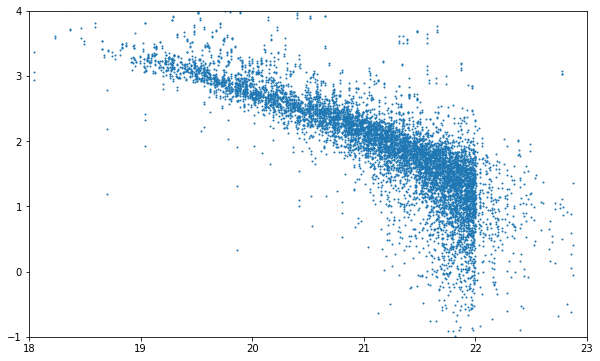

In [445]:
plt.figure(figsize=(10,6))
plt.scatter(new_catalog_short['zfibermag'],np.log10(new_catalog_short['DELTACHI2']),s=1)
plt.xlim(18,23)
plt.ylim(-1,4)

Text(0.5, 1.0, '850<EFFTIME_DARK<950 zfibermag<21.72')

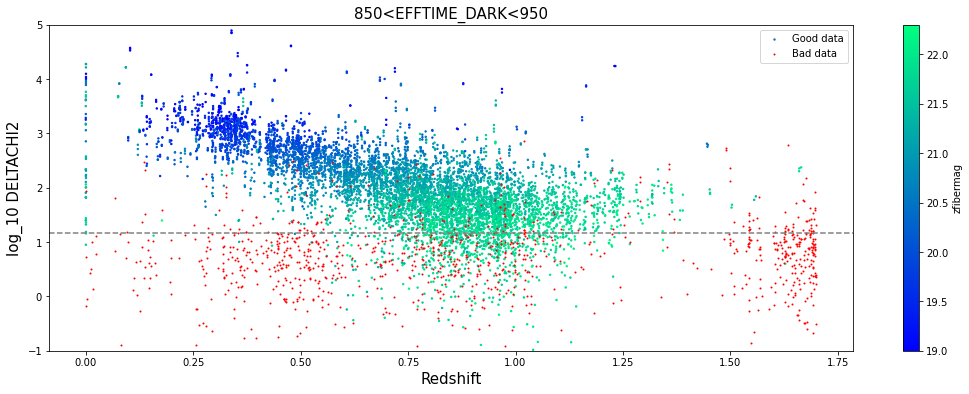

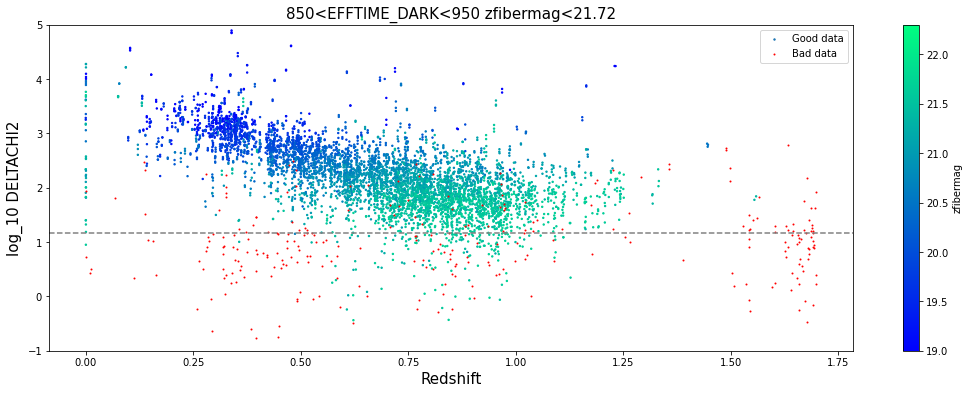

In [437]:
plt.figure(figsize=(18,6))

good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(new_catalog_short)
plt.scatter(good['Z'],np.log10(good['DELTACHI2']),s=2,c=good['zfibermag'],vmin=19,vmax=22.3,cmap=cm.winter,label='Good data')
plt.colorbar(label='zfibermag')
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2']),s=1,color='r',label='Bad data')
plt.axhline(np.log10(15),ls='--',color='grey')
plt.legend()
plt.ylim(-1,5)
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('log_10 DELTACHI2',fontsize=15)
plt.title('850<EFFTIME_DARK<950',fontsize=15)

plt.figure(figsize=(18,6))
good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(new_catalog_short[new_catalog_short['zfibermag']<21.72])
plt.scatter(good['Z'],np.log10(good['DELTACHI2']),s=2,c=good['zfibermag'],vmin=19,vmax=22.3,cmap=cm.winter,label='Good data')
plt.colorbar(label='zfibermag')
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2']),s=1,color='r',label='Bad data')
plt.axhline(np.log10(15),ls='--',color='grey')
plt.legend()
plt.ylim(-1,5)
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('log_10 DELTACHI2',fontsize=15)
plt.title('850<EFFTIME_DARK<950 zfibermag<21.72',fontsize=15)

Text(18.5, 0.5, 'Z<1.4')

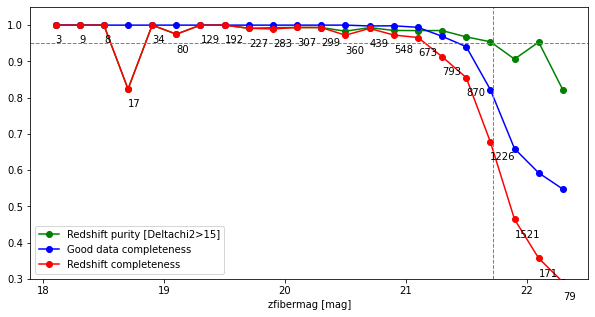

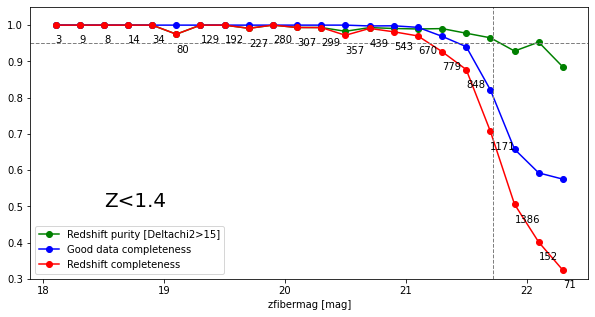

In [446]:
mag_bin = np.arange(18.,22.5,0.2)
#mag_bin = [18.,21.5]
plot_curve(new_catalog_short,mag_bin)
plot_curve(new_catalog_short[(new_catalog_short['Z']<1.4)],mag_bin)
plt.text(18.5,0.5,'Z<1.4',fontsize=20)

# Using the whole SV catalog to do the analysis

In [451]:
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
dataname = 'alltiles_LRGzinfo.fits'
all_catalog = Table.read(diretory+dataname)

In [536]:
search_deep = np.where((all_catalog['subset']!='all') & 
                            (all_catalog['subset']=='deep') & 
                            (all_catalog['EFFTIME_DARK']>3000) & (all_catalog['TARGETS']!='BGS+MWS'))
catalog_LRG = all_catalog[search_deep[0]].copy()
print('Number of deep exposures:', len(catalog_LRG))

Number of deep exposures: 24973


2. Selecting the short exposures coadds with EFFTIME_dark>700 (not deep or all)

In [537]:
search_LRG_short = np.where((all_catalog['subset']!='all') & (all_catalog['subset']!='deep') & (all_catalog['TARGETS']!='BGS+MWS') & 
                            (all_catalog['EFFTIME_DARK']>850) & (all_catalog['EFFTIME_DARK']<950))
catalog_LRG_short = all_catalog[search_LRG_short[0]].copy()
print('Number of short exposures:', len(catalog_LRG_short))

Number of short exposures: 26045


In [538]:
new_catalog_LRG_short = catalog_LRG_short[['TARGETID','Z','subset','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER','RZR']].to_pandas()
new_catalog_LRG = catalog_LRG['TARGETID','Z','subset','TILEID','DELTACHI2','EFFTIME_DARK','FIBERFLUX_Z','EBV','ZWARN','FIBER','RZR'].to_pandas()
new_catalog_LRG['zfibermag']=-2.5*np.log10(new_catalog_LRG['FIBERFLUX_Z'])+22.5-1.211*new_catalog_LRG['EBV']
new_catalog_LRG['best_z']=new_catalog_LRG['Z']
new_catalog_LRG['best_quality']=0
new_catalog_LRG['best_quality'][(new_catalog_LRG['best_z']<1.4) & (new_catalog_LRG['DELTACHI2']>15)]=4

(array([ 288.,  509.,  739., 1126., 1529., 2197., 2959., 3398., 3224.,
        2939., 2358., 1722., 1248.,  592.,  356.,  192.,  107.,   59.,
          26.,   12.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

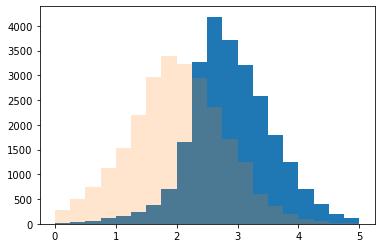

In [539]:
plt.hist(np.log10(new_catalog_LRG['DELTACHI2']),bins=20,range=(0,5))
plt.hist(np.log10(new_catalog_LRG_short['DELTACHI2']),bins=20,range=(0,5),alpha=0.2)

## Key assumption: We assume that for LRGs with z<1.4 and with DELTACHI2>15 with EFFTIME_dark>3000, the Redrock redshifts are the true redshifts. 

In [540]:
catalog_LRG_match = new_catalog_LRG_short.merge(new_catalog_LRG,on='TARGETID',how='left',suffixes=("","_deep"))
final_match_catalog = catalog_LRG_match[catalog_LRG_match['TILEID_deep']==catalog_LRG_match['TILEID']]
final_match_catalog['dz']=abs(final_match_catalog['best_z']-final_match_catalog['Z'])/(1.+final_match_catalog['best_z'])

Text(0.5, 1.0, '850<EFFTIME_DARK<950 zfibermag<21.72')

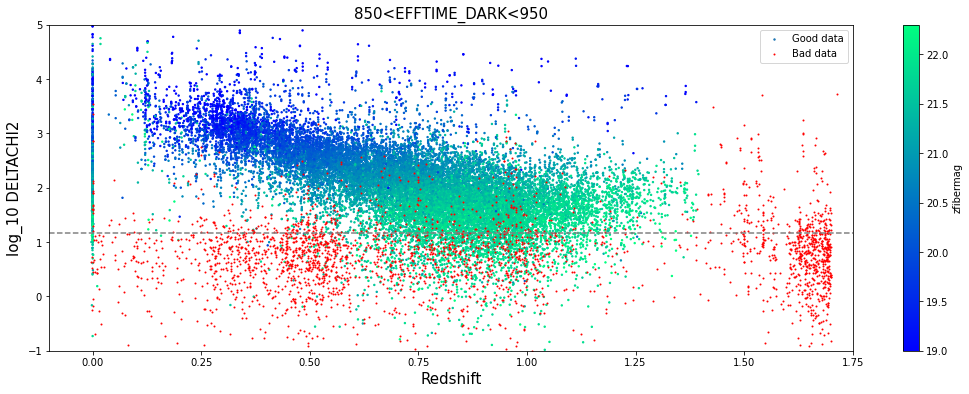

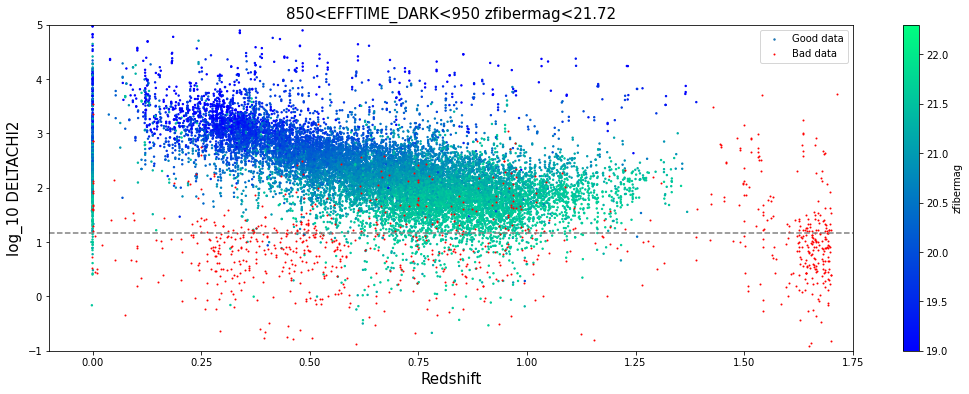

In [548]:
plt.figure(figsize=(18,6))

good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(final_match_catalog)
plt.scatter(good['Z'],np.log10(good['DELTACHI2']),s=2,c=good['zfibermag'],vmin=19,vmax=22.3,cmap=cm.winter,label='Good data')
plt.colorbar(label='zfibermag')
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2']),s=1,color='r',label='Bad data')
plt.axhline(np.log10(15),ls='--',color='grey')
plt.legend()
plt.xlim(-0.1,1.75)
plt.ylim(-1,5)
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('log_10 DELTACHI2',fontsize=15)
plt.title('850<EFFTIME_DARK<950',fontsize=15)

plt.figure(figsize=(18,6))
good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(final_match_catalog[final_match_catalog['zfibermag']<21.72])
plt.scatter(good['Z'],np.log10(good['DELTACHI2']),s=2,c=good['zfibermag'],vmin=19,vmax=22.3,cmap=cm.winter,label='Good data')
plt.colorbar(label='zfibermag')
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2']),s=1,color='r',label='Bad data')
plt.axhline(np.log10(15),ls='--',color='grey')
plt.legend()
plt.xlim(-0.1,1.75)
plt.ylim(-1,5)
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('log_10 DELTACHI2',fontsize=15)
plt.title('850<EFFTIME_DARK<950 zfibermag<21.72',fontsize=15)

24800
24010


Text(18.5, 0.5, 'Z<1.4')

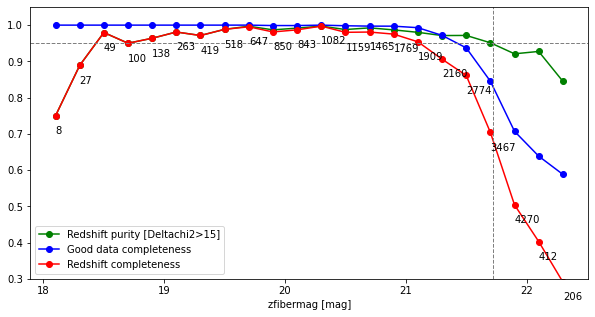

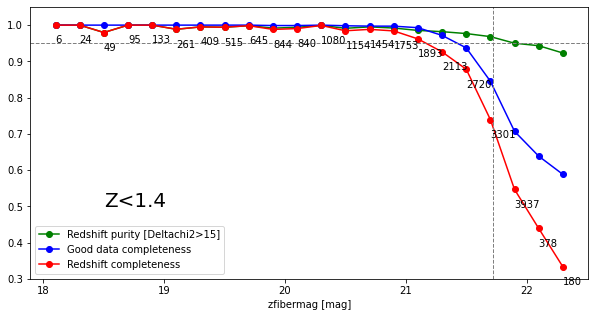

In [545]:
mag_bin = np.arange(18.,22.5,0.2)
#mag_bin = [18.,21.72]
plot_curve(final_match_catalog,mag_bin)
print(len(final_match_catalog))
print(len(final_match_catalog[(final_match_catalog['Z']<1.4)]))
plot_curve(final_match_catalog[(final_match_catalog['Z']<1.4)],mag_bin)
plt.text(18.5,0.5,'Z<1.4',fontsize=20)